In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')
# 禁用科学计数法


#设置最多显示的行
pd.set_option('display.max_rows',500) 
#对matplotlib进行设置
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.style.use('fivethirtyeight')

#解决负号显示不了的问题
plt.rcParams['axes.unicode_minus']=False

In [2]:
train = pd.read_csv('C:/Users/Administrator/input/train_new.csv')
test = pd.read_csv('C:/Users/Administrator/input/test_new.csv')



In [3]:
train_label = train.drop_duplicates('渔船ID')
train_label['type'].value_counts(1)



拖网   0.62
围网   0.23
刺网   0.15
Name: type, dtype: float64

In [4]:
for col in train.columns:
    print(col,train[col].isnull().sum())

#数据不存在空值

渔船ID 0
X 0
Y 0
速度 0
方向 0
time 0
type 0
dX 0
dY 0
加速度 0
方向变化 0
month 0
day 0
hour 0


In [9]:
#展示各类渔船X，Y移动轨迹
def show_path(type_name):
    ids = train[train['type']==type_name]['渔船ID'].unique()
    ids = [ids[np.random.randint(len(ids))] for x in range(20)]
    t = train[train['渔船ID'].isin(ids)]

    f, ax = plt.subplots(5,4, figsize=(16,20))
    for index, cur_id in enumerate(ids):
        cur = t[t['渔船ID']==cur_id]
        i = index//4
        j = index % 4
        ax[i,j].plot(cur['X'], cur['Y'])
#         if i==0 and j==0:
        ax[i,j].set_title(cur_id)


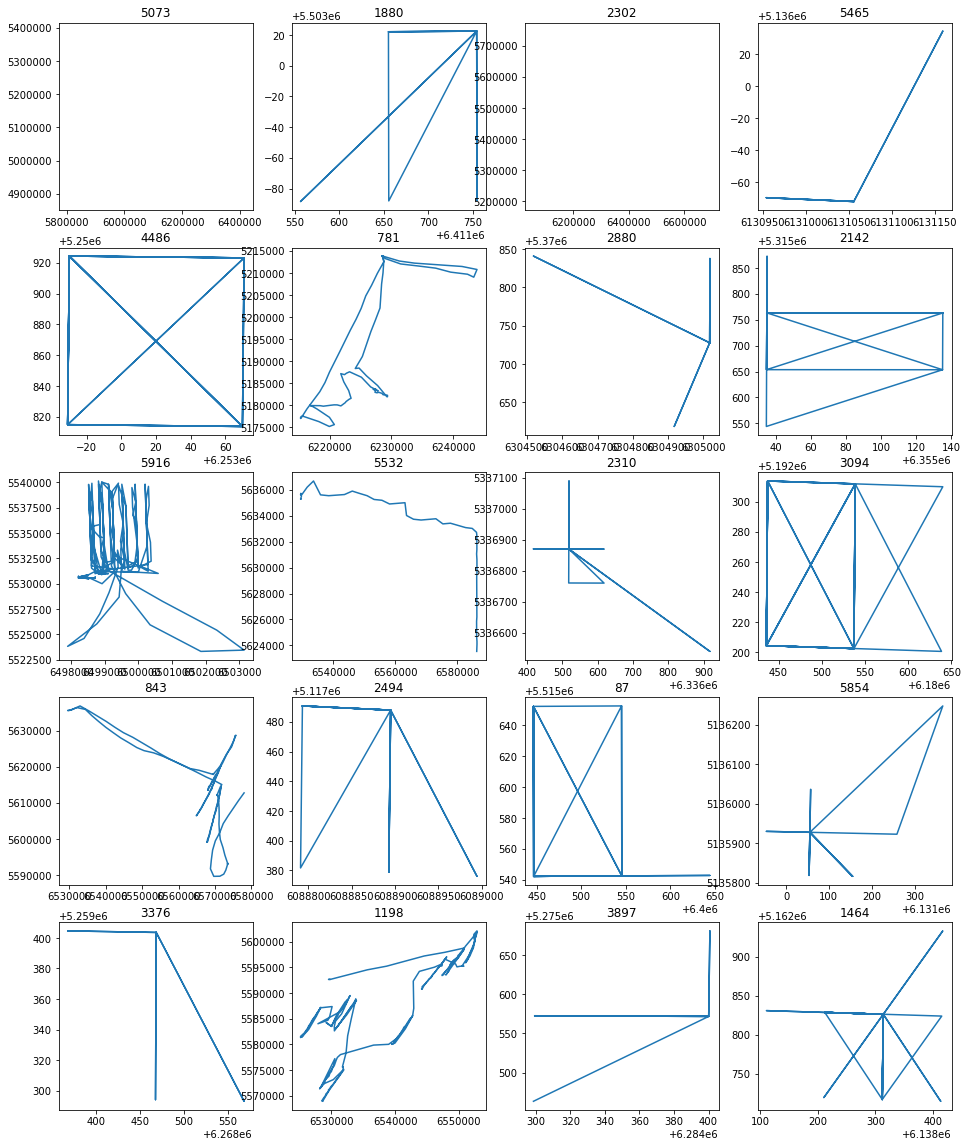

In [10]:
show_path('刺网')

In [33]:
#探究基本不动的渔船
error_result = []
for name,df in train.groupby('渔船ID'):
    if df['X'].max() - df['X'].min() < 10 and df['Y'].max() - df['Y'].min() < 10:
        error_result.append(name)
print(len(error_result))
print(error_result)

204
[9, 30, 32, 47, 131, 183, 231, 283, 408, 568, 633, 653, 677, 746, 748, 780, 816, 846, 925, 1008, 1019, 1106, 1140, 1299, 1360, 1362, 1378, 1380, 1387, 1395, 1441, 1452, 1479, 1489, 1514, 1546, 1590, 1595, 1612, 1617, 1689, 1708, 1709, 1740, 1774, 1823, 1826, 1844, 1872, 1875, 1920, 2021, 2066, 2067, 2129, 2150, 2168, 2218, 2219, 2254, 2284, 2286, 2302, 2318, 2321, 2339, 2362, 2393, 2478, 2567, 2575, 2587, 2678, 2690, 2694, 2769, 2798, 2823, 2867, 2870, 2919, 2963, 2976, 3023, 3037, 3041, 3096, 3117, 3138, 3214, 3271, 3308, 3423, 3475, 3476, 3509, 3510, 3549, 3566, 3580, 3614, 3615, 3650, 3707, 3710, 3792, 3861, 3867, 3882, 3963, 4027, 4062, 4078, 4138, 4161, 4163, 4205, 4233, 4288, 4291, 4334, 4352, 4363, 4377, 4385, 4436, 4463, 4539, 4583, 4614, 4627, 4650, 4784, 4848, 4872, 4879, 4939, 5028, 5073, 5078, 5206, 5207, 5262, 5294, 5328, 5379, 5406, 5520, 5525, 5543, 5545, 5548, 5588, 5594, 5705, 5781, 5807, 5840, 5879, 5891, 5958, 5991, 5993, 6021, 6035, 6041, 6054, 6104, 6117, 6119,

In [28]:
train_label = train[train['渔船ID'].isin(error_result)].drop_duplicates('渔船ID')
train_label['type'].value_counts()
#得出结论：X的标准差 <1 and Y 的标准差 < 1 的数据是船基本不动的数据，判断是否跟停靠位置有关，没关的话就是脏数据了。
#记得要删除那些平均速度大于1的，因为他们位置不变，速度却高于1，肯定就是出问题了。
#新发现：不仅可以对从没动过的船进行停靠判断，还是可以对一定时间范围速度不动，位置不动的所有船进行停靠分类

拖网    126
刺网     50
围网     28
Name: type, dtype: int64

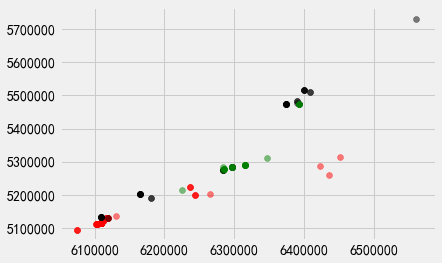

In [29]:
#接下来要对这些基本不动的船进行停靠位置分类（它们的位置就取第一个X，Y）
tuo = train_label[train_label['type'] == '拖网']
ci = train_label[train_label['type'] == '刺网']
wei = train_label[train_label['type'] == '围网']
plt.scatter(tuo['X'],tuo['Y'],c = 'r',alpha=0.5)
plt.scatter(ci['X'],ci['Y'],c='k',alpha=0.5)
plt.scatter(wei['X'],wei['Y'],c='g',alpha=0.5)
plt.show()

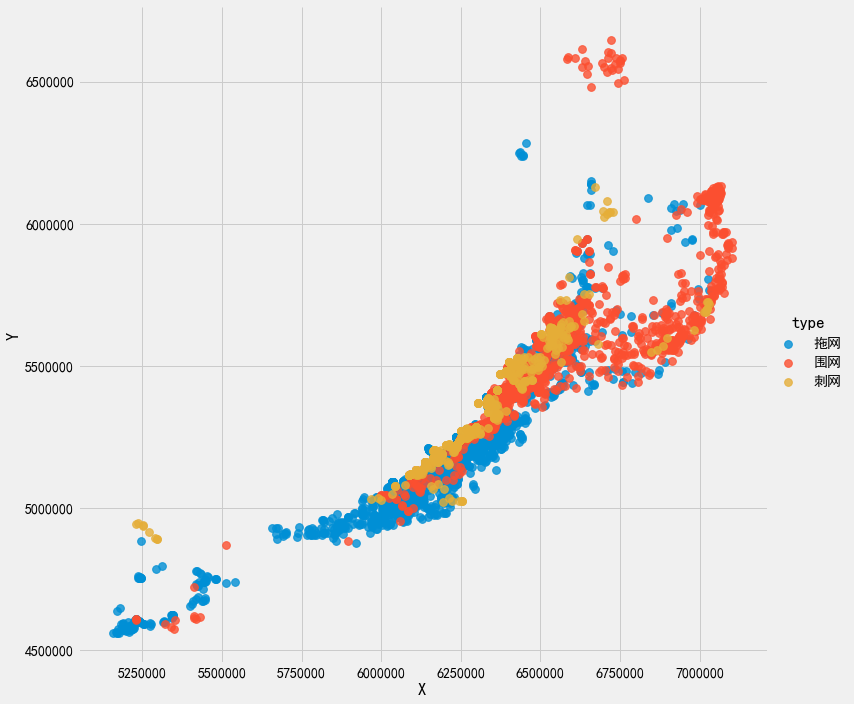

In [37]:
#测试下所有数据的位置（以第一个位置粗略统计）
features = []
for name,df in train.groupby('渔船ID'):
    features.append([df['X'].mean(),df['Y'].mean(),df['type'].iloc[0]])
df = pd.DataFrame(features,columns=['X','Y','type'])

    
sns.lmplot('X','Y',hue='type',data=df,
          scatter_kws={'alpha':0.8,'s':60},fit_reg=False,
          size=10,aspect=1.1)

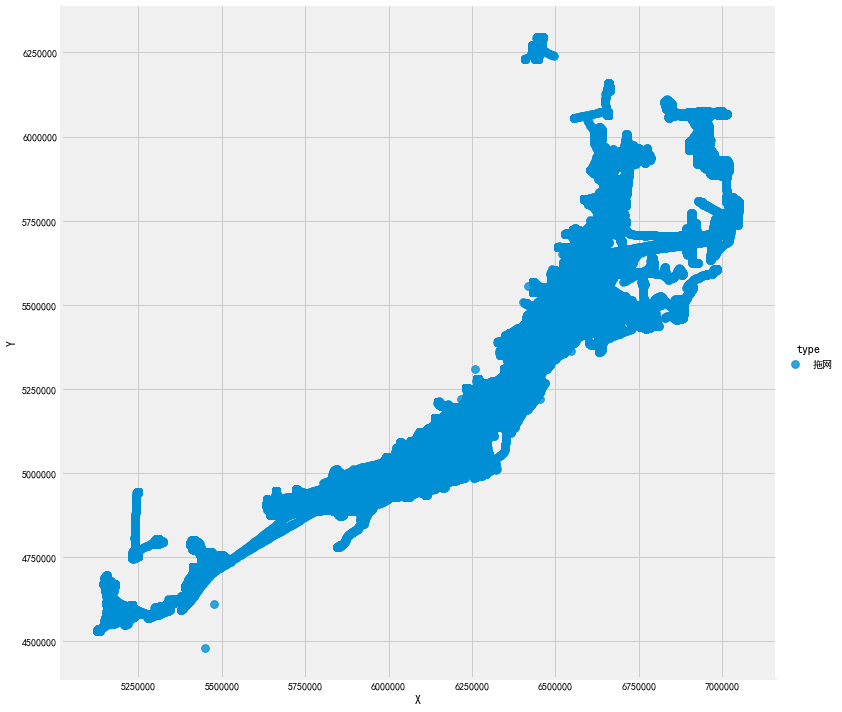

In [85]:
#测试下所有数据的位置（某个类型）
#train_1 = train.drop_duplicates('渔船ID')
'''
sns.lmplot('X','Y',hue='type',data=df[df['type']=='拖网'],
          scatter_kws={'alpha':0.8,'s':60},fit_reg=False,
          size=10,aspect=1.1)
'''
sns.lmplot('X','Y',hue='type',data=train[train['type']=='拖网'],
          scatter_kws={'alpha':0.8,'s':60},fit_reg=False,
          size=10,aspect=1.1)

In [3]:
#以下是对train中XY异常的数据进行处理
error_XY_index_1 = train.loc[(train['X'] < 5750000) & (train['Y'] > 5000000),'渔船ID'].index.values
error_XY_index_2 = train.loc[(train['X'] < 6000000) & (train['Y'] < 4350000),'渔船ID'].index.values
error_XY_index_3 = train.loc[(train['X'] > 6000000) & (train['Y'] < 4900000),'渔船ID'].index.values
error_XY_index_4 = train.loc[(train['X'] > 6800000) & (train['Y'] > 6200000),'渔船ID'].index.values

error_XY_index = np.hstack([error_XY_index_1,error_XY_index_2,error_XY_index_3,error_XY_index_4])

In [4]:
error_XY_index

array([ 111561,  645106,  878506, 1264513, 1422980, 1424559, 1744414,
       2005212, 2280926, 2280927, 2389182, 2534293,  405938,  818666,
       1262425, 1264514, 1270330, 1559949, 1604769, 2461018, 2104056,
       2545366, 2545367, 1814580], dtype=int64)

In [5]:
#先对上一条的渔船信息的dX、dY进行修改再删除
def update_dX_dY(error_XY_index):
    for i in error_XY_index:
        try:
            train.loc[train.index==i-1,'dX'] = train.loc[train.index==i+1,'X'].iloc[0]- train.loc[train.index==i-1,'X'].iloc[0]
            train.loc[train.index==i-1,'dY'] = train.loc[train.index==i+1,'Y'].iloc[0] - train.loc[train.index==i-1,'Y'].iloc[0]
        except:
            pass
#对其异常值进行删除处理（和上面的二选一处理）
def delete_error_XY(error_XY_index):
    train.drop(error_XY_index,inplace=True)
update_dX_dY(error_XY_index)
delete_error_XY(error_XY_index)

In [6]:
train.loc[train.index==1604768]

,渔船ID,X,Y,速度,方向,time,type,dX,dY,加速度,方向变化,month,day,hour
1604768,4749,6881787.53,5673459.20,0.81,242,1900-10-28 17:13:56,围网,1404.76,1290.92,0.00,0,10,28,17


In [7]:
#还有个别点的处理
test_2 = train.loc[(train['X'] > 6550000) & (train['Y'] > 6200000),['渔船ID','type']]
test_2[test_2['type']=='拖网']

,渔船ID,type
1130210,3644,拖网


In [8]:
#以下方法二选一（取中位数还是直接删除）
#train.iloc[1130210,[1,2]] = [train.loc[train['渔船ID'] == 3644,'X'].mode()[0],train.loc[train['渔船ID'] == 3644,'Y'].mode()[0]]
#注意：train中还有两三个点没处理，后期要记得处理
update_dX_dY([1130210])
train.drop(1130210,inplace=True)

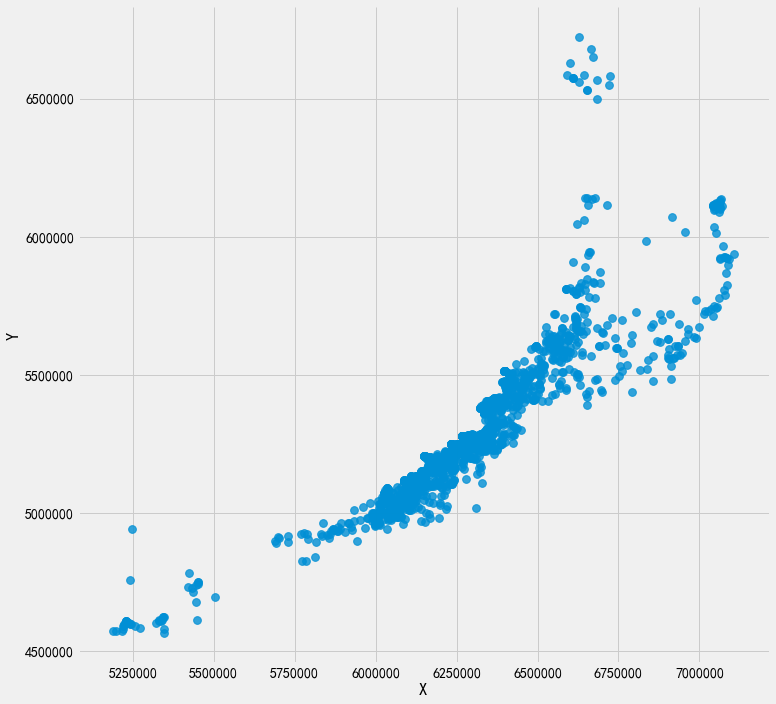

In [31]:
test_1 = test.drop_duplicates('渔船ID')

features = []
for name,df in test.groupby('渔船ID'):
    features.append([df['X'].mean(),df['Y'].mean()])
df_test = pd.DataFrame(features,columns=['X','Y'])

sns.lmplot('X','Y',data=df_test,
          scatter_kws={'alpha':0.8,'s':60},fit_reg=False,
          size=10,aspect=1.1)

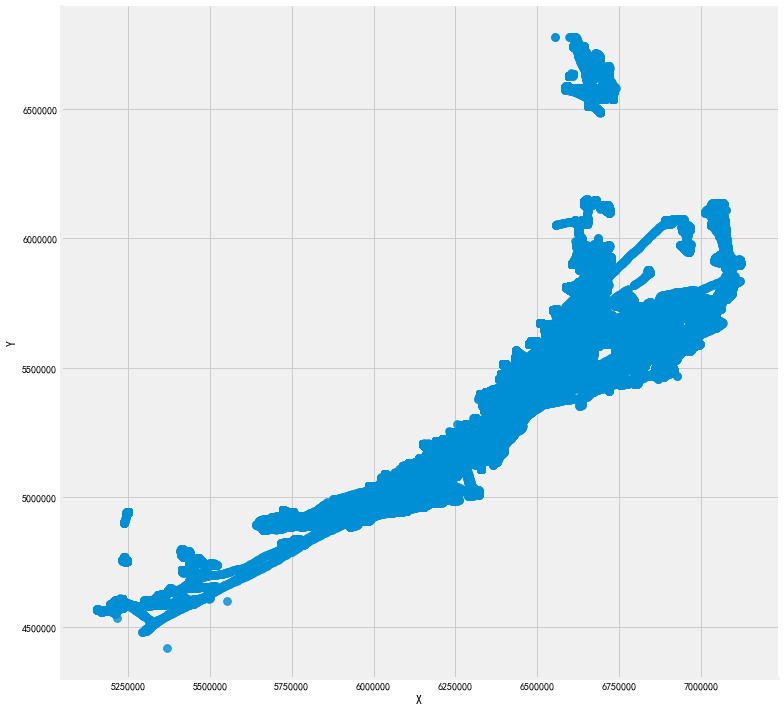

In [69]:
sns.lmplot('X','Y',data=test,
          scatter_kws={'alpha':0.8,'s':60},fit_reg=False,
          size=10,aspect=1.1)

In [9]:
#以下是对test中XY异常的数据进行处理
test_error_XY_index_1 = test.loc[(test['X'] < 6000000) & (test['Y'] > 5200000),'渔船ID'].index.values
test_error_XY_index_2 = test.loc[(test['X'] > 5800000) & (test['Y'] < 4800000),'渔船ID'].index.values
test_error_XY_index_3 = test.loc[(test['X'] < 5500000) & (test['Y'] < 4400000),'渔船ID'].index.values
test_error_XY_index = np.hstack([test_error_XY_index_1,test_error_XY_index_2,test_error_XY_index_3])
print(test_error_XY_index)

[  9718  26290 408419 532083 618179  75507 441411 498599  94379  94380
 515068 532077 532078]


In [10]:
#先对上一条的渔船信息的dX、dY进行修改再删除
def test_update_dX_dY(error_XY_index):
    for i in error_XY_index:
        try:
            test.loc[test.index==i-1,'dX'] = test.loc[test.index==i+1,'X'].iloc[0] - test.loc[test.index==i-1,'X'].iloc[0]
            test.loc[test.index==i-1,'dY'] = test.loc[test.index==i+1,'Y'].iloc[0] - test.loc[test.index==i-1,'Y'].iloc[0]
        except:
            pass
#对XY的异常值进行删除处理（二选一）
def test_delete_error_XY(test_error):
    test.drop(test_error,inplace=True)
test_update_dX_dY(test_error_XY_index)
test_delete_error_XY(test_error_XY_index)

Text(0, 0.5, 'Frequency')

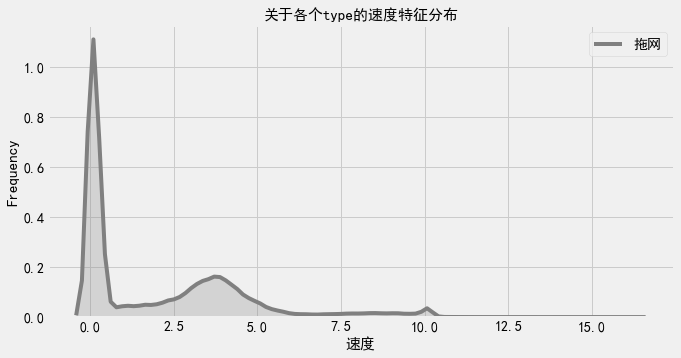

In [18]:
f,ax = plt.subplots(figsize=(10,5))
sns.kdeplot(train.loc[(train['type']=='拖网'),'速度'],color='gray',shade=True,label='拖网')
#sns.kdeplot(train.loc[(train['type']=='围网') & (train['速度'] > 6),'速度'],color='g',shade=True,label='围网')
#sns.kdeplot(train.loc[(train['type']=='围网'),'速度'],color='g',shade=True,label='围网')
#sns.kdeplot(train.loc[(train['type']=='刺网'),'速度'],color = 'r',shade=True,label='刺网')
plt.title('关于各个type的速度特征分布', fontsize = 15)
plt.xlabel("速度", fontsize = 15)
plt.ylabel('Frequency', fontsize = 15)

Text(0, 0.5, 'Frequency')

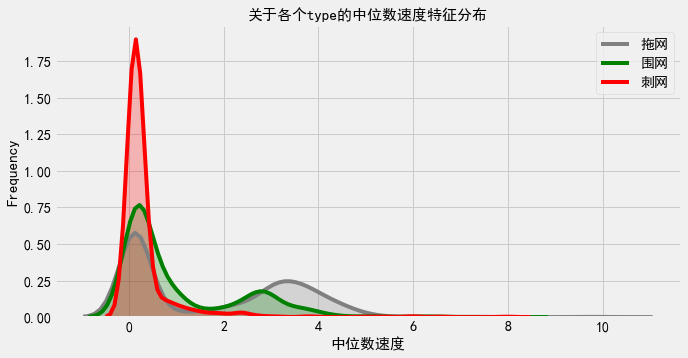

In [78]:
features_sudu = []

for name,df in train.groupby('渔船ID'):
    features_sudu.append([df['渔船ID'].iloc[0],df['速度'].median(),df['type'].iloc[0]])
df_sd = pd.DataFrame(features_sudu,columns=['渔船ID','中位数速度','type'])

f,ax = plt.subplots(figsize=(10,5))
sns.kdeplot(df_sd.loc[(df_sd['type']=='拖网'),'中位数速度'],color='gray',shade=True,label='拖网')
sns.kdeplot(df_sd.loc[(df_sd['type']=='围网'),'中位数速度'],color='g',shade=True,label='围网')
sns.kdeplot(df_sd.loc[(df_sd['type']=='刺网'),'中位数速度'],color='r',shade=True,label='刺网')
plt.title('关于各个type的中位数速度特征分布', fontsize = 15)
plt.xlabel("中位数速度", fontsize = 15)
plt.ylabel('Frequency', fontsize = 15)

In [90]:
df_sd.loc[df_sd['中位数速度'] > 3,'type'].value_counts()

拖网    1529
围网     146
刺网       9
Name: type, dtype: int64

Text(0, 0.5, 'Frequency')

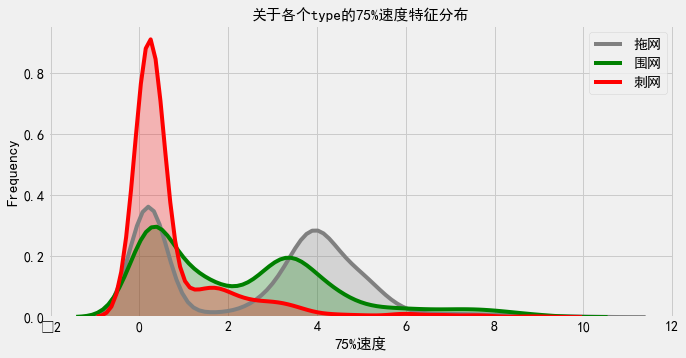

In [77]:
features_sudu_75 = []

for name,df in train.groupby('渔船ID'):
    features_sudu_75.append([df['速度'].quantile(0.75),df['type'].iloc[0]])
df_sd_75 = pd.DataFrame(features_sudu_75,columns=['75%速度','type'])

f,ax = plt.subplots(figsize=(10,5))
sns.kdeplot(df_sd_75.loc[(df_sd_75['type']=='拖网'),'75%速度'],color='gray',shade=True,label='拖网')
sns.kdeplot(df_sd_75.loc[(df_sd_75['type']=='围网'),'75%速度'],color='g',shade=True,label='围网')
sns.kdeplot(df_sd_75.loc[(df_sd_75['type']=='刺网'),'75%速度'],color='r',shade=True,label='刺网')
plt.title('关于各个type的75%速度特征分布', fontsize = 15)
plt.xlabel("75%速度", fontsize = 15)
plt.ylabel('Frequency', fontsize = 15)

In [117]:
df_sd_75.describe()

,75%速度
count,7000.00
mean,2.32
std,2.13
min,0.00
25%,0.22
50%,2.21
75%,3.99
max,10.20


In [122]:
train[train['type']=='围网'].describe([.25,.50,.75,.90,.95,.99,.999])

,渔船ID,X,Y,速度,方向
count,626607.00,626607.00,626607.00,626607.00,626607.00
mean,3552.54,6518444.74,5500673.40,1.82,124.03
std,2027.93,287019.01,281524.78,2.66,118.13
min,4.00,5227084.12,4489628.82,0.00,0.00
25%,1816.00,6334288.56,5294280.42,0.11,0.00
50%,3527.00,6449583.24,5453187.07,0.32,101.00
75%,5346.00,6667925.19,5623300.26,2.81,223.00
90%,6361.00,7006077.94,5849954.71,6.42,305.00
95%,6661.00,7053175.96,6092651.74,8.42,335.00
99%,6930.00,7076548.68,6549926.87,10.09,356.00


In [87]:
train.loc[train['速度'] > 25,['渔船ID','type']].loc[:,'type'].value_counts()

拖网    127
围网     51
刺网     21
Name: type, dtype: int64

In [ ]:
train[train['type']=='刺网'].describe([.25,.50,.75,.90,.95,.99,.999])

In [ ]:
train[train['type']=='拖网'].describe([.25,.50,.75,.90,.95,.99,.999])

In [ ]:
f,ax = plt.subplots(figsize=(10,5))
sns.kdeplot(train.loc[(train['type']=='拖网'),'方向'],color='gray',shade=True,label='拖网')
sns.kdeplot(train.loc[(train['type']=='围网'),'方向'],color='g',shade=True,label='围网')
sns.kdeplot(train.loc[(train['type']=='刺网'),'方向'],color = 'r',shade=True,label='刺网')
plt.title('关于各个type的方向特征分布', fontsize = 15)
plt.xlabel("方向", fontsize = 15)
plt.ylabel('Frequency', fontsize = 15)

In [ ]:
#继续找出train中的异常值并修改它
test_sd = train.loc[train['速度'] > 20,'type'].value_counts()
test_sd

In [120]:
train[train['type']=='拖网'].describe([.25,.50,.75,.90,.95,.99,.999])

,渔船ID,X,Y,速度,方向
count,1681225.00,1681225.00,1681225.00,1681225.00,1681225.00
mean,3460.79,6186964.57,5176131.07,2.02,114.16
std,2020.01,217586.20,185294.00,2.49,115.49
min,0.00,5125337.88,4480840.94,0.00,0.00
25%,1696.00,6102850.97,5098968.79,0.11,0.00
50%,3464.00,6182684.71,5164759.17,0.32,81.00
75%,5198.00,6264879.05,5241259.51,3.67,218.00
90%,6253.00,6382310.31,5363771.85,4.91,285.00
95%,6626.00,6527347.87,5524053.66,7.29,324.00
99%,6926.00,6700221.93,5802525.73,10.09,354.00


Text(0, 0.5, 'Frequency')

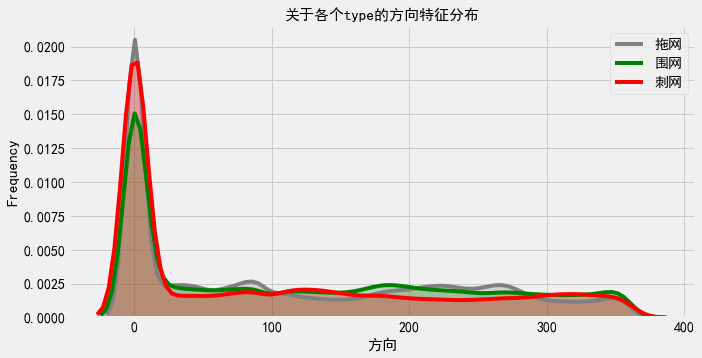

In [118]:
f,ax = plt.subplots(figsize=(10,5))
sns.kdeplot(train.loc[(train['type']=='拖网'),'方向'],color='gray',shade=True,label='拖网')
sns.kdeplot(train.loc[(train['type']=='围网'),'方向'],color='g',shade=True,label='围网')
sns.kdeplot(train.loc[(train['type']=='刺网'),'方向'],color = 'r',shade=True,label='刺网')
plt.title('关于各个type的方向特征分布', fontsize = 15)
plt.xlabel("方向", fontsize = 15)
plt.ylabel('Frequency', fontsize = 15)

Text(0, 0.5, 'Frequency')

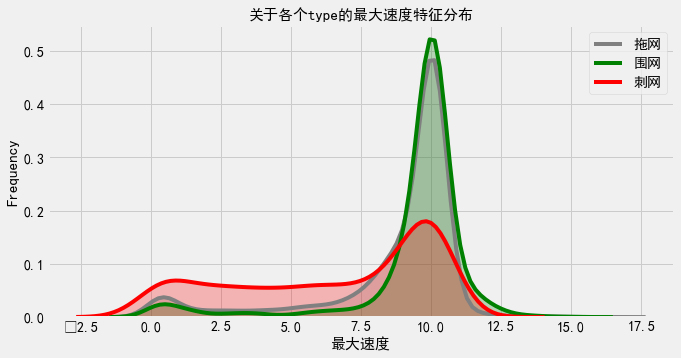

In [119]:
features_sudu_max = []

for name,df in train.groupby('渔船ID'):
    features_sudu_max.append([df['速度'].max(),df['type'].iloc[0]])
df_sd_max = pd.DataFrame(features_sudu_max,columns=['最大速度','type'])

f,ax = plt.subplots(figsize=(10,5))
sns.kdeplot(df_sd_max.loc[(df_sd_max['type']=='拖网'),'最大速度'],color='gray',shade=True,label='拖网')
sns.kdeplot(df_sd_max.loc[(df_sd_max['type']=='围网'),'最大速度'],color='g',shade=True,label='围网')
sns.kdeplot(df_sd_max.loc[(df_sd_max['type']=='刺网'),'最大速度'],color='r',shade=True,label='刺网')
plt.title('关于各个type的最大速度特征分布', fontsize = 15)
plt.xlabel("最大速度", fontsize = 15)
plt.ylabel('Frequency', fontsize = 15)

#总结（关于速度最大值）：一半来说，渔船最快也就围网渔船，能达到15-16节，而超过17节以上的应该判定为异常值。因为在17-20这一速度段落上只有3条信息，而20以上却有
#500到600条，不符合正常逻辑上的分布。所以，可以判定17节以上的信息为异常信息。（可以删去）

In [11]:
#删除train中速度上的异常值（大于17节的删除）
train_sd_error = train.loc[train['速度'] > 17,'渔船ID'].index.values
update_dX_dY(train_sd_error)
train.drop(train_sd_error,inplace=True)

In [12]:
#删除test中速度大于17节的渔船信息
test_sd_error = test.loc[test['速度'] > 17,'渔船ID'].index.values
test_update_dX_dY(test_sd_error)
test.drop(test_sd_error,inplace=True)

In [13]:
#再继续寻找速度上的异常值
#探究基本不动却速度并不低或方向一直不变的渔船
error_result = []
for name,df in train.groupby('渔船ID'):
    if df['X'].max() - df['X'].min() < 10 and df['Y'].max() - df['Y'].min() < 10 and df['速度'].mean() > 1 or df['方向'].min() == df['方向'].max() and df['方向'].min() != 0:
        error_result.append(name)
print(len(error_result))
print(error_result)
error_sd_fx = train.loc[train['渔船ID'].isin(error_result)]

27
[746, 846, 1019, 1299, 1709, 1740, 1872, 2168, 2302, 2339, 2867, 2976, 3096, 3423, 3566, 3615, 3710, 4205, 4363, 5705, 5891, 6228, 6535, 6605, 6746, 6754, 6791]


In [14]:
#同时也对test进行检测
test_error_result = []
for name,df in test.groupby('渔船ID'):
    if df['X'].max() - df['X'].min() < 10 and df['Y'].max() - df['Y'].min() < 10 and df['速度'].mean() > 1 or df['方向'].min() == df['方向'].max() and df['方向'].min() != 0:
        test_error_result.append(name)
print(len(test_error_result))
print(test_error_result)
error_sd_fx = train.loc[train['渔船ID'].isin(test_error_result)]

7
[7158, 7437, 7647, 8190, 8359, 8511, 8627]


In [15]:
#对这些速度和方向错误的点进行修改
train.loc[train['渔船ID'].isin(error_result),['速度','方向']] = 0.00,0
#对这些test中速度和方向错误的点进行修改
test.loc[test['渔船ID'].isin(test_error_result),['速度','方向']] = 0.00,0

Text(0, 0.5, 'Frequency')

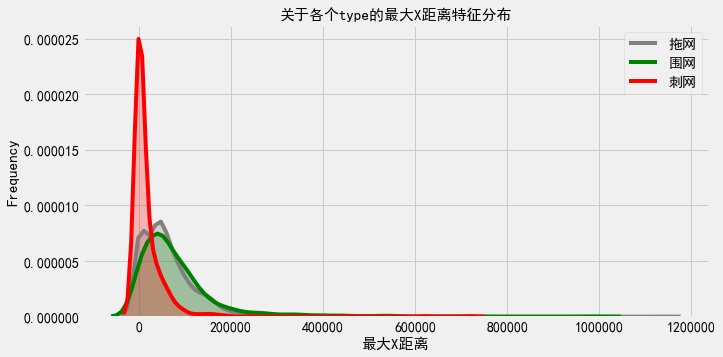

In [121]:
#渔船的行驶最大距离的分布观察
features_XY_max = []

for name,df in train.groupby('渔船ID'):
    features_XY_max.append([df['渔船ID'].iloc[0],df['X'].max() - df['X'].min(),df['Y'].max() - df['Y'].min(),df['type'].iloc[0]])
df_xy_max = pd.DataFrame(features_XY_max,columns=['渔船ID','最大X距离','最大Y距离','type'])

f,ax = plt.subplots(figsize=(10,5))
sns.kdeplot(df_xy_max.loc[(df_xy_max['type']=='拖网'),'最大X距离'],color='gray',shade=True,label='拖网')
sns.kdeplot(df_xy_max.loc[(df_xy_max['type']=='围网'),'最大X距离'],color='g',shade=True,label='围网')
sns.kdeplot(df_xy_max.loc[(df_xy_max['type']=='刺网'),'最大X距离'],color='r',shade=True,label='刺网')
plt.title('关于各个type的最大X距离特征分布', fontsize = 15)
plt.xlabel("最大X距离", fontsize = 15)
plt.ylabel('Frequency', fontsize = 15)

In [139]:
df_xy_max.loc[df_xy_max['最大X距离'] > 600000]

,渔船ID,最大X距离,最大Y距离,type
1305,1305,647668.77,335935.34,围网
1386,1386,718674.62,339540.68,刺网
2260,2260,728200.46,787811.67,围网
3659,3659,685461.78,403003.75,围网
4076,4076,986477.06,1074064.39,围网
4818,4818,623023.75,226503.03,刺网
5757,5757,1022084.56,993408.13,拖网
6674,6674,1138430.41,1125039.37,拖网


In [48]:
train[train['渔船ID']==1253]

,渔船ID,X,Y,速度,方向,time,type,dX,dY,加速度,方向变化,month,day,hour
111496,1253,6710812.66,5736005.82,0.70,10,1900-11-06 23:55:40,围网,-269.80,-711.31,-1.03,-174,11,6,23
111497,1253,6711621.16,5738137.39,3.78,184,1900-11-06 23:25:42,围网,-159.84,-1108.89,-0.54,2,11,6,23
111498,1253,6711781.52,5739249.98,4.32,182,1900-11-06 23:15:40,围网,-445.96,-1229.34,0.00,-13,11,6,23
111499,1253,6712228.97,5740483.41,4.32,195,1900-11-06 23:05:38,围网,-259.21,-1125.44,0.11,11,11,6,23
111500,1253,6712486.01,5741599.47,4.21,184,1900-11-06 22:55:43,围网,-254.48,-1230.77,0.22,0,11,6,22
111501,1253,6712739.65,5742826.14,3.99,184,1900-11-06 22:45:45,围网,39.56,-1307.40,0.00,8,11,6,22
111502,1253,6712699.50,5744153.15,3.99,176,1900-11-06 22:35:36,围网,-60.87,-1238.45,-0.11,-5,11,6,22
111503,1253,6712759.45,5745373.03,4.10,181,1900-11-06 22:25:45,围网,-59.33,-1207.82,0.32,1,11,6,22
111504,1253,6712819.38,5746592.93,3.78,180,1900-11-06 22:15:39,围网,-59.30,-1207.84,-0.53,-8,11,6,22
111505,1253,6712879.27,5747812.85,4.32,188,1900-11-06 22:05:33,围网,86.94,-1270.12,-0.38,45,11,6,22


In [16]:
test_dx = abs(train['dX'])
test_dx.describe()

count    2699031.00
mean         389.35
std        14910.21
min            0.00
25%            0.00
50%            0.00
75%          510.18
max     14264960.47
Name: dX, dtype: float64

Text(0, 0.5, 'Frequency')

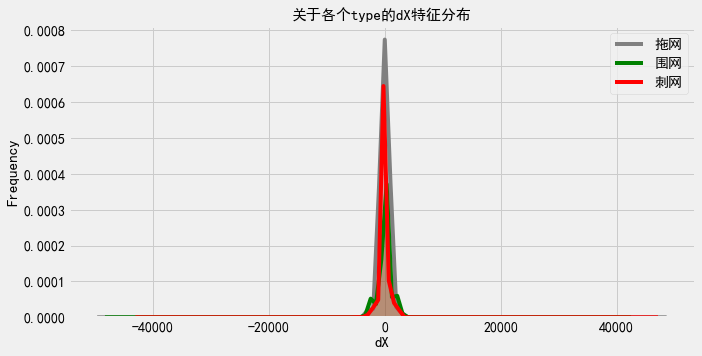

In [61]:
#train_1 = train.loc[(train['dX'] < 1) & (train['dX'] > -1)]
train_1 = train.loc[(train['dX'] > -50000) & (train['dX'] < 50000) & (train['dX'] != 0.00)]
f,ax = plt.subplots(figsize=(10,5))
sns.kdeplot(train_1.loc[(train_1['type']=='拖网'),'dX'],color='gray',shade=True,label='拖网')
sns.kdeplot(train_1.loc[(train_1['type']=='围网'),'dX'],color='g',shade=True,label='围网')
sns.kdeplot(train_1.loc[(train_1['type']=='刺网'),'dX'],color='r',shade=True,label='刺网')
plt.title('关于各个type的dX特征分布', fontsize = 15)
plt.xlabel("dX", fontsize = 15)
plt.ylabel('Frequency', fontsize = 15)

In [55]:
test_9 = train[(train['dX'] > 50000) | (train['dX'] < -50000)].index.values
test_9

array([], dtype=int64)

In [56]:
test_10 = test[(test['dX'] > 50000) | (test['dX'] < -50000)].index.values
test_10

array([], dtype=int64)

In [54]:
#未完成（不准，还有没对Y进行处理）
#继续清洗掉X、Y异常值
def clean_XY_error(error_index,df):
    for i in error_index:
        try:
            if abs(train.loc[train.index==i + 1,'dX'].iloc[0]) > 10000:
                df.loc[df.index==i,'dX'] = df.loc[df.index==i,'X'].iloc[0]- df.loc[df.index==i+2,'X'].iloc[0]
                df.loc[df.index==i,'dY'] = df.loc[df.index==i,'Y'].iloc[0] - df.loc[df.index==i+2,'Y'].iloc[0]
                df.drop(i+1,inplace=True)
            else:
                df.loc[df.index==i-1,'dX'] = df.loc[df.index==i-1,'X'].iloc[0]- df.loc[df.index==i+1,'X'].iloc[0]
                df.loc[df.index==i-1,'dY'] = df.loc[df.index==i-1,'Y'].iloc[0] - df.loc[df.index==i+1,'Y'].iloc[0]
                df.drop(i,inplace=True)
        except:
            df.drop(i,inplace=True)
clean_XY_error(test_9,train)
clean_XY_error(test_10,test)

In [34]:
train.loc[train.index.isin(test_9)]

,渔船ID,X,Y,速度,方向,time,type,dX,dY,加速度,方向变化,month,day,hour
21839,1048,6671405.56,6566294.97,0.32,186,1900-10-29 08:22:21,围网,-51045.20,-68452.20,192.00,-132,10,29,8
98142,1220,6165385.59,5201899.04,0.00,297,1900-10-30 06:14:12,刺网,-721537.84,-403828.53,-0.90,247,10,30,6
137870,1314,6257889.26,5235983.80,10.09,148,1900-10-29 14:08:34,拖网,-146970.19,140225.17,21.33,20,10,29,14
198750,1458,6436300.97,5462853.75,9.12,100,1900-11-09 11:34:21,围网,-198194.98,47137.13,-6.71,9,11,9,11
203080,1468,6313557.87,5241750.45,5.50,241,1900-11-12 12:01:32,拖网,-65817.41,-48875.82,-5.50,10,11,12,12
237173,1547,5817795.27,4945134.61,1.78,61,1900-11-07 23:27:51,拖网,-57301.97,-31126.70,-57.69,0,11,7,23
253183,1584,5964870.63,5002170.65,5.40,71,1900-11-09 11:02:46,拖网,-370658.76,-50491.60,180.00,10,11,9,11
259016,1598,6246728.14,5241258.27,0.22,0,1900-11-19 13:59:25,拖网,-478940.67,43181.51,-15.08,-360,11,19,13
289523,1666,6540147.23,5392925.20,6.48,30,1900-10-29 07:10:30,围网,-68998.01,-70566.34,7.64,-10,10,29,7
300620,1692,6246321.39,5240934.98,0.22,102,1900-10-31 14:38:58,拖网,-60592.31,-10964.21,-3.29,-258,10,31,14


In [36]:
train[train['渔船ID']==1220]

,渔船ID,X,Y,速度,方向,time,type,dX,dY,加速度,方向变化,month,day,hour
98068,1220,6165385.59,5201899.04,0.22,0,1900-10-30 23:55:34,刺网,0.00,0.00,0.00,0,10,30,23
98069,1220,6165385.59,5201899.04,0.22,0,1900-10-30 23:45:31,刺网,0.00,0.00,0.11,0,10,30,23
98070,1220,6165385.59,5201899.04,0.11,0,1900-10-30 23:35:33,刺网,0.00,0.00,0.00,0,10,30,23
98071,1220,6165385.59,5201899.04,0.11,0,1900-10-30 23:35:32,刺网,0.00,0.00,0.00,0,10,30,23
98072,1220,6165385.59,5201899.04,0.11,0,1900-10-30 23:16:23,刺网,0.00,0.00,0.00,0,10,30,23
98073,1220,6165385.59,5201899.04,0.11,0,1900-10-30 22:55:31,刺网,0.00,0.00,0.00,0,10,30,22
98074,1220,6165385.59,5201899.04,0.11,0,1900-10-30 22:45:29,刺网,0.00,0.00,0.12,0,10,30,22
98075,1220,6165385.59,5201899.04,0.00,0,1900-10-30 22:36:06,刺网,0.00,0.00,0.00,-169,10,30,22
98076,1220,6165385.59,5201899.04,0.00,169,1900-10-30 22:15:28,刺网,0.00,0.00,0.00,169,10,30,22
98077,1220,6165385.59,5201899.04,0.00,0,1900-10-30 21:55:28,刺网,0.00,0.00,0.00,0,10,30,21


In [53]:
train.describe([.90,.99,.999])

,渔船ID,X,Y,速度,方向,dX,dY,加速度,方向变化,month,day,hour
count,2698890.00,2698890.00,2698890.00,2698890.00,2698890.00,2698890.00,2698890.00,2698890.00,2698890.00,2698890.00,2698890.00,2698890.00
mean,3496.03,6277230.85,5271175.94,1.78,114.77,-6.07,-8.36,-0.01,-0.00,10.85,14.60,11.61
std,2020.77,269787.84,254382.64,2.44,116.65,861.08,5707.06,1.92,116.81,0.35,8.67,6.97
min,0.00,5125337.88,4489628.82,0.00,0.00,-342983.95,-9244243.48,-1260.00,-360.00,10.00,1.00,0.00
50%,3502.00,6246522.26,5229446.15,0.32,81.00,0.00,0.00,0.00,0.00,11.00,14.00,12.00
90%,6290.00,6592463.96,5602272.80,4.91,292.00,724.89,675.51,0.70,135.00,11.00,29.00,21.00
99%,6928.00,7056205.28,6111644.41,10.09,355.00,2322.29,2094.14,5.45,336.00,11.00,31.00,23.00
99.9%,6992.00,7089317.05,6584042.21,10.15,360.00,3070.40,3149.09,9.52,356.00,11.00,31.00,23.00
max,6999.00,7133785.48,6653548.81,16.19,360.00,46724.20,329582.41,592.20,360.00,11.00,31.00,23.00


In [113]:
test.describe()

,渔船ID,X,Y,速度,方向
count,782197.00,782197.00,782197.00,782197.00,782197.00
mean,7996.07,6276005.40,5275919.92,1.82,116.16
std,578.55,263124.30,265440.17,2.46,116.02
min,7000.00,5154657.44,4418718.46,0.00,0.00
25%,7493.00,6118355.64,5114763.85,0.11,0.00
50%,7997.00,6246525.27,5240825.56,0.32,81.00
75%,8496.00,6388942.51,5383127.02,3.29,218.00
max,8999.00,7123876.70,6778623.50,15.97,360.00


In [57]:
train.to_csv('C:/Users/Administrator/input/train_new_use.csv',index=False)

In [58]:
test.to_csv('C:/Users/Administrator/input/test_new_use.csv',index=False)